In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats as stat
from tqdm import tqdm
plt.rcParams["figure.figsize"] = (7, 7)


In [9]:
# Remember to add in cleaning code.
df = pd.read_csv('final_df.csv')

# Removing a weird CSV formatting thing.
df.drop('Unnamed: 0', axis=1, inplace=True)


In [5]:
# length_before_outliers = len(df)

# standard_dev = df.groupby('route')['duration'].std() * 2
# remove_index = []
# outliers_above = dict(df.groupby('route')['duration'].mean() + standard_dev)

# for k,v in tqdm(outliers_above.items()):
#     route_df = df[df['route'] == k]
#     lower = route_df['duration'].mean() - standard_dev[k]
#     outlier_index = route_df[route_df['duration'].apply(lambda x: x >= v or x <= lower)].index
#     df.drop(outlier_index, inplace=True)

# # for k,v in outliers_below.items():
# #     route_df = df[df['route'] == k]
# #     outlier_index = route_df[route_df['duration'].apply(lambda x: x <= v)].index
# #     remove_index.append(outlier_index)

# # for i in remove_index:
# #     df.drop(i, inplace=True)
# print('number of samples before outliers are removed: ', length_before_outliers)
# print('number of samples after outliers are removed:  ', len(df))

# top_500_df = df[df['route'].isin(df['route'].value_counts()[:500].index)]
# top_500_df.to_csv('final_df.csv')


100%|██████████| 12019/12019 [32:14<00:00,  6.21it/s] 

number of samples before outliers are removed:  1278986
number of samples after outliers are removed:   1239599


In [10]:
# Formatting the "conditions" column to only include 4 categories.
df['conditions'].replace('Partially cloudy', 'cloudy', inplace=True)
df['conditions'].replace('Overcast', 'cloudy', inplace=True)
df['conditions'].replace('Rain, Partially cloudy', 'Rain', inplace=True)
df['conditions'].replace('Rain, Overcast', 'Rain', inplace=True)
df['conditions'].replace('Snow, Partially cloudy', 'Snow', inplace=True)
df['conditions'].replace('Snow, Overcast', 'Snow', inplace=True)
df['conditions'].unique()


array(['cloudy', 'Clear', 'Rain', 'Snow'], dtype=object)

In [11]:
# Creating a new "hour" column.

df['starttime'] = df['starttime'].apply(lambda x: x[1:-1].split(','))
df['hour'] = df['starttime'].apply(
    lambda x: int(x[3].strip().replace('\'', '')))
# sns.histplot(df['hour'])


def time_day(x):
    ''' Reformats the starttime column to a categorical variable.
    '''
    if x >= 6 and x <= 10:
        return 'morning'
    elif x >= 11 and x <= 14:
        return 'lunch'
    elif x >= 17 and x <= 19:
        return 'evening'
    else:
        return 'night'

# df['hour'] = df['hour'].apply(time_day)
# print(df['hour'].value_counts())


In [12]:
def change_temp(x):
    ''' Reformats the temperature column from integers to three different categorical variables.
    '''
    if x > 10:
        return 'warm'
    elif x >= 0:
        return 'coldish'
    else:
        return 'rlly_cold'


print(df['temperature'].apply(change_temp).value_counts())
df['temperature'] = df['temperature'].apply(change_temp)


warm         351707
coldish      103571
rlly_cold     14489
Name: temperature, dtype: int64


In [13]:
def day_week(x):
    ''' Reformats "day_of_week" column to a binary category.
    '''
    if x != 'Saturday' and x != 'Sunday' and x != 'Friday':
        return 'working day'
    else:
        return 'weekend'


df['day_of_week'] = df['day_of_week'].apply(day_week)


In [14]:
reg_df = df[['duration', 'member', 'days_since_Jan1_2010',
             'day_of_week', 'temperature', 'conditions', 'route', 'hour']]

# Creating Dummy Variables:
member = pd.get_dummies(reg_df['member'], drop_first=True, prefix='member')
conditions = pd.get_dummies(reg_df['conditions'], drop_first=True)
day_of_week = pd.get_dummies(reg_df['day_of_week'], drop_first=True)
# temp = pd.get_dummies(reg_df['temperature'], drop_first=True)
time_of_day = pd.get_dummies(reg_df['hour'], drop_first=True)

reg_df = pd.concat((reg_df, member, conditions, day_of_week,
                   time_of_day), axis=1)  # Without Temp
reg_df.drop(['member', 'day_of_week', 'conditions',
            'temperature', 'hour'], axis=1, inplace=True)


In [39]:
def permut_p_value(resid, days_since, num_perm=25000):
    """ Calculates the p-value by permuting the days since Jan 1st and calculating the correlation of the days since Jan1 with the OLS residuals.
    The null hypothesis is that there should be no correlation when permuting the days since and calculating the correlation with the residuals.
    """
    corr_avg = []
    for i in range(num_perm):
        perm = np.random.permutation(days_since)  # Permutes the column.
        corr_avg.append(np.corrcoef(results.resid, perm)[1, 0])
    corr_avg = np.array(corr_avg)
    p_val = sum(np.abs(corr_avg) > np.abs(
        np.corrcoef(results.resid, days_since)[1, 0]))/num_perm  # Checks if the real correlation is significantly different from the permuted one.
    return p_val


In [40]:
p_vals = []
model_resuls = []
number_observations = []

for route in tqdm(reg_df.route.unique()):
    # Getting the pandas dataframe into the right form for least squares.
    X = reg_df[reg_df['route'] == route]
    days_since = X['days_since_Jan1_2010']
    y = X['duration']
    X.drop(['route', 'days_since_Jan1_2010', 'duration'], axis=1, inplace=True)
    number_observations.append(len(X))

    # Running OLS
    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()

    # Collecting the results
    p_val = permut_p_value(results.resid, days_since)
    p_vals.append(p_val)
    model_resuls.append(results)


  0%|          | 0/500 [00:00<?, ?it/s]/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
100%|██████████| 500/500 [24:34<00:00,  2.95s/it]


Smallest number of observations:  522
Average Number of Observations:  939.534


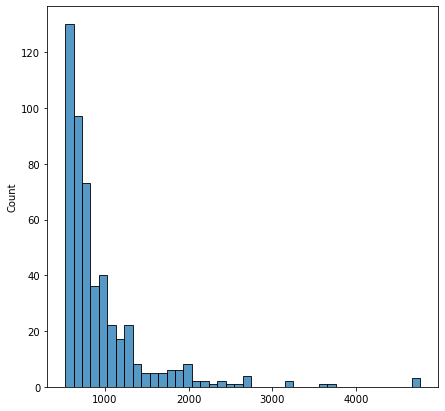

In [41]:
sns.histplot(number_observations)
print('Smallest number of observations: ', min(number_observations))
print('Average Number of Observations: ',  np.mean(number_observations))


Text(0.5, 1.0, 'Histogram of P-values')

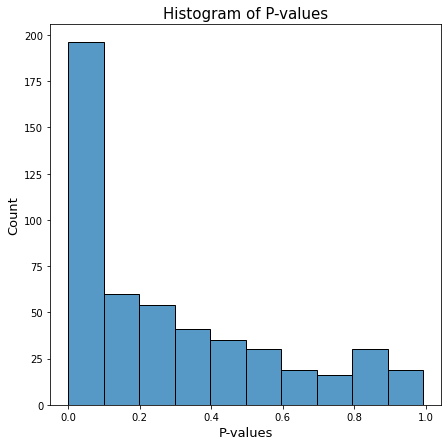

In [42]:
p = sns.histplot(p_vals)
p.set_xlabel('P-values', fontsize=13)
p.set_ylabel('Count', fontsize=13)
p.set_title('Histogram of P-values', fontsize=15)


#### Going over Multiple Testing:

In [43]:
reject_lst, corrected_pvals_bon, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='bonferroni', returnsorted=False)
print('Number of rejections using Bonferroni ', sum(reject_lst))

reject_lst, corrected_pvals, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='fdr_tsbh', returnsorted=False)
print('Number of rejections using two stage fdr correction (non-negative)', sum(reject_lst))

reject_lst, corrected_pvals, z, k = stat.multitest.multipletests(
    p_vals, alpha=0.05, method='fdr_bh', returnsorted=False)
print('Number of rejections using BH', sum(reject_lst))


Number of rejections using Bonferroni  26
Number of rejections using two stage fdr correction (non-negative) 111
Number of rejections using BH 104


In [58]:
signif_pvals = np.where(corrected_pvals_bon <= 0.01)
signif_pvals
# for i in signif_pvals:
#     print(reg_df.route.unique()[i])

# [7,114, 104, 184]


(array([  5,   6,   7,  38,  82,  92, 104, 114, 184, 189, 267, 371, 416,
        486]),)

/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='duration'>

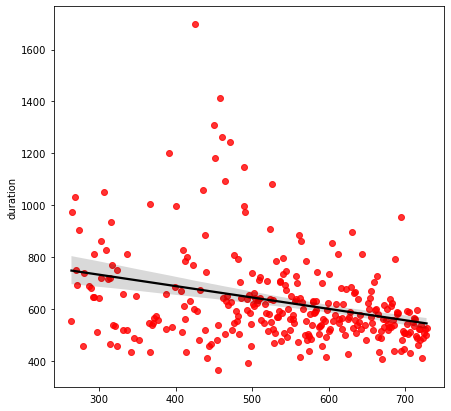

In [75]:
mask = reg_df[reg_df['route'] == reg_df.route.unique()[114]]
sns.regplot(mask['days_since_Jan1_2010'].unique(), mask.groupby(
    'days_since_Jan1_2010')['duration'].mean(), line_kws={"color": "black"}, scatter_kws={"color": "red"})


/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='days_since_Jan1_2010', ylabel='duration'>

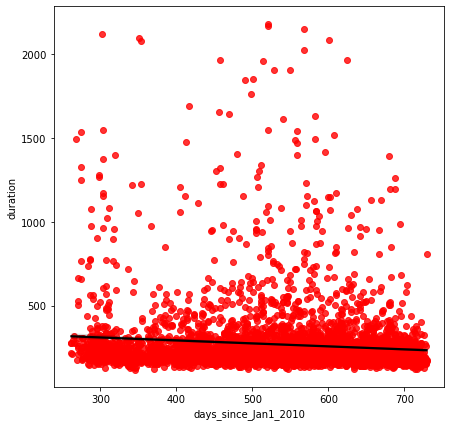

In [56]:
sns.regplot(mask['days_since_Jan1_2010'], mask['duration'], line_kws={
            "color": "black"}, scatter_kws={"color": "red"})


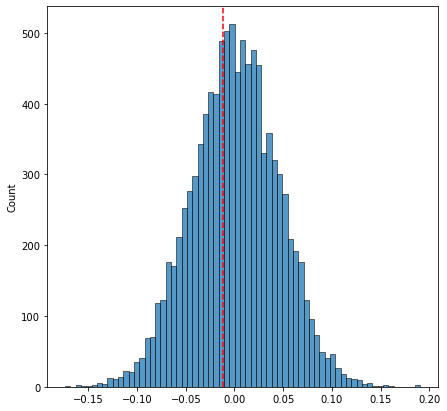

In [210]:
# This is for code testing purposes by looking at single routes only.

test_route = reg_df.route.unique()[268]
X = reg_df.drop(['duration'], axis=1)
X = X[X['route'] == test_route]
y = reg_df[reg_df['route'] == test_route]['duration']
days_since = X['days_since_Jan1_2010']
X.drop(['route', 'days_since_Jan1_2010'], axis=1, inplace=True)
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()

correlation_permutation = []
real_corr = np.corrcoef(results.resid, days_since)[1, 0]
for i in range(10000):
    perm = np.random.permutation(days_since)
    correlation_permutation.append(np.corrcoef(results.resid, perm)[1, 0])

sns.histplot(correlation_permutation)
plt.axvline(real_corr, color='r', linestyle='--')


In [291]:
np.corrcoef(results.resid, days_since)[1, 0]
print(results.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               duration   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.360
Method:                 Least Squares   F-statistic:                     46.43
Date:                Tue, 15 Feb 2022   Prob (F-statistic):           8.09e-52
Time:                        13:55:02   Log-Likelihood:                -3837.1
No. Observations:                 566   AIC:                             7690.
Df Residuals:                     558   BIC:                             7725.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1191.0220     54.076     22.025      0.000    1084.804    1297.240
member_True  -574.5643     35.477    -16.195      0.000    -644.250    -504.879
Rain           -8.2310     39.276     -0.210      0.834     -85.379      68.917
Snow         5.466e-13   2.81e-13      1.943      0.053   -6.01e-15     1.1e-12
cloudy        -17.8860     39.404     -0.454      0.650     -95.283      59.511
working day   -19.7004     21.240     -0.928      0.354     -61.421      22.020
lunch         -18.2170     30.551     -0.596      0.551     -78.227      41.793
morning       -67.2877     23.846     -2.822      0.005    -114.127     -20.448
night         -10.1398     32.254     -0.314      0.753     -73.493      53.214
==============================================================================
Omnibus:                      471.407   Durbin-Watson:                   1.818
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16917.047
Skew:                           3.391   Prob(JB):                         0.00
Kurtosis:                      28.910   Cond. No.                     6.12e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.91e-33. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [20]:
# This will track the real correlation values (not the permuted ones) for plotting and analysis.

lst_real_corr = []
for route in tqdm(reg_df.route.unique()):
    X = reg_df.drop(['duration'], axis=1)
    X = X[X['route'] == route]
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_Jan1_2010']
    X.drop(['route', 'days_since_Jan1_2010'], axis=1, inplace=True)

    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()

    real_corr = np.corrcoef(results.resid, days_since)[1, 0]
    lst_real_corr.append(real_corr)


  0%|          | 0/500 [00:00<?, ?it/s]/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
100%|██████████| 500/500 [00:29<00:00, 16.76it/s]


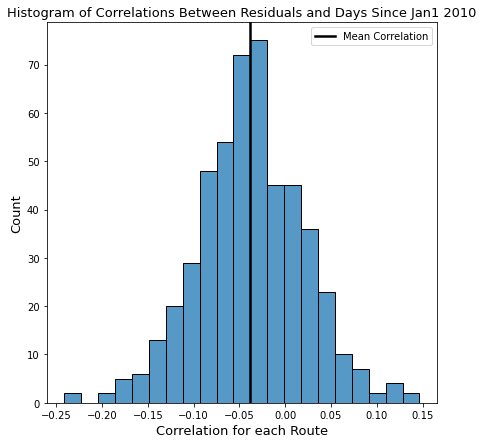

In [21]:
p = sns.histplot(lst_real_corr)
p.set_xlabel('Correlation for each Route', fontsize=13)
p.set_ylabel('Count', fontsize=13)
p.set_title(
    'Histogram of Correlations Between Residuals and Days Since Jan1 2010', fontsize=13)

plt.axvline(np.mean(lst_real_corr), color='k', linestyle='-',
            linewidth=2.5, label='Mean Correlation')
plt.legend()


In [22]:
np.mean(lst_real_corr)


-0.03795092416228695

In [24]:
positive = 0
neg = 0
signif_pvals = np.where(corrected_pvals <= 0.05)[0]
for i in signif_pvals:
    if lst_real_corr[i] >= 0:
        positive += 1
        print(i)
    else:
        neg += 1

    # print(reg_df.route.unique()[i])
    # print('Correlation sign ' , lst_real_corr[i])

neg/(neg+positive)


184
187
195
224
238
357
367
469


0.9238095238095239

In [160]:
np.where(corrected_pvals >= 0.7)


(array([  8,  14,  28,  30,  34,  35,  37,  40,  45,  47,  48,  56,  65,
         66,  70,  72,  87,  89,  90, 108, 129, 138, 143, 147, 163, 164,
        171, 173, 177, 191, 194, 204, 206, 211, 212, 220, 221, 225, 237,
        243, 250, 260, 262, 264, 265, 268, 272, 273, 274, 276, 279, 280,
        282, 283, 290, 295, 314, 319, 323, 332, 340, 343, 345, 346, 349,
        351, 356, 358, 359, 363, 372, 374, 377, 380, 387, 394, 402, 407,
        419, 424, 427, 434, 448, 458, 473, 475, 477, 484, 487, 490, 493,
        496]),)

In [111]:
# Slightly Changing original function so it can plot residuals.
def permut_p_value(resid, days_since, num_perm=25000):
    perm_corr = []
    for i in range(num_perm):
        perm = np.random.permutation(days_since)
        perm_corr.append(np.corrcoef(results.resid, perm)[1, 0])
    perm_corr = np.array(perm_corr)
    p_val = sum(np.abs(perm_corr) > np.abs(
        np.corrcoef(results.resid, days_since)[1, 0]))/num_perm
    return p_val, perm_corr


In [82]:
significant_routes = [7, 114, 104, 184, 255, 432, 499]


In [161]:
significant_routes = [184, 114, 104, 255, 432, 72]
lst_real_corr = []
perm_corr = []
lst_residuals = []
lst_days_since = []
p_vals = []
for route_index in significant_routes:
    route = reg_df.route.unique()[route_index]
    X = reg_df.drop(['duration'], axis=1)
    X = X[X['route'] == route]
    y = reg_df[reg_df['route'] == route]['duration']
    days_since = X['days_since_Jan1_2010']
    X.drop(['route', 'days_since_Jan1_2010'], axis=1, inplace=True)

    X = sm.add_constant(X)
    model = sm.OLS(y, X)
    results = model.fit()
    real_corr = np.corrcoef(results.resid, days_since)[1, 0]

    lst_residuals.append(results.resid)
    lst_days_since.append(days_since)
    lst_real_corr.append(real_corr)

    p_val, corr_avg = permut_p_value(results.resid, days_since)
    p_vals.append(p_val)
    perm_corr.append(corr_avg)
    model_resuls.append(results)


/Users/gabrielnicholson/opt/anaconda3/envs/py39/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [162]:
plot_resid = []
plot_days_since = []
for i in range(len(lst_residuals)):
    k = pd.DataFrame({'lst_residuals': lst_residuals[i], 'lst_days_since': lst_days_since[i]}).groupby(
        'lst_days_since')['lst_residuals'].mean()
    plot_days_since.append(k.index)
    plot_resid.append(k.values)


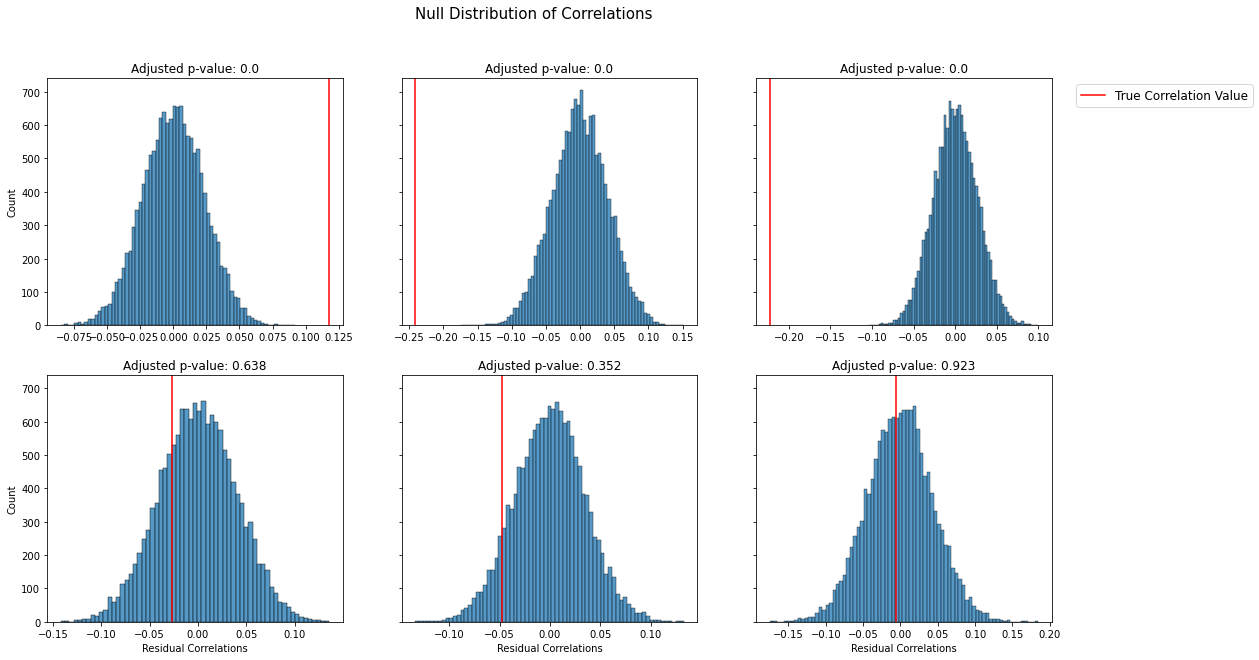

In [167]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

sns.histplot(ax=axes[0, 0], data=perm_corr[0], )
axes[0, 0].axvline(lst_real_corr[0], color='r')
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

sns.histplot(ax=axes[0, 1], data=perm_corr[1], )
axes[0, 1].axvline(lst_real_corr[1], color='r', label='True Correlation Value')
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

sns.histplot(ax=axes[0, 2], data=perm_corr[2], )
axes[0, 2].axvline(lst_real_corr[2], color='r', label='True Correlation Value')
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')

sns.histplot(ax=axes[1, 0], data=perm_corr[3], )
axes[1, 0].axvline(lst_real_corr[3], color='r')
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
axes[1, 0].set_xlabel('Residual Correlations')

sns.histplot(ax=axes[1, 1], data=perm_corr[4], )
axes[1, 1].axvline(lst_real_corr[4], color='r', label='True Correlation Value')
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
axes[1, 1].set_xlabel('Residual Correlations')

sns.histplot(ax=axes[1, 2], data=perm_corr[5], )
axes[1, 2].axvline(lst_real_corr[5], color='r', label='True Correlation Value')
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
axes[1, 2].set_xlabel('Residual Correlations')

plt.suptitle('Null Distribution of Correlations', fontsize=15)

axes[0, 2].legend(loc="upper right", bbox_to_anchor=(
    1.7, 1), prop={'size': 12})


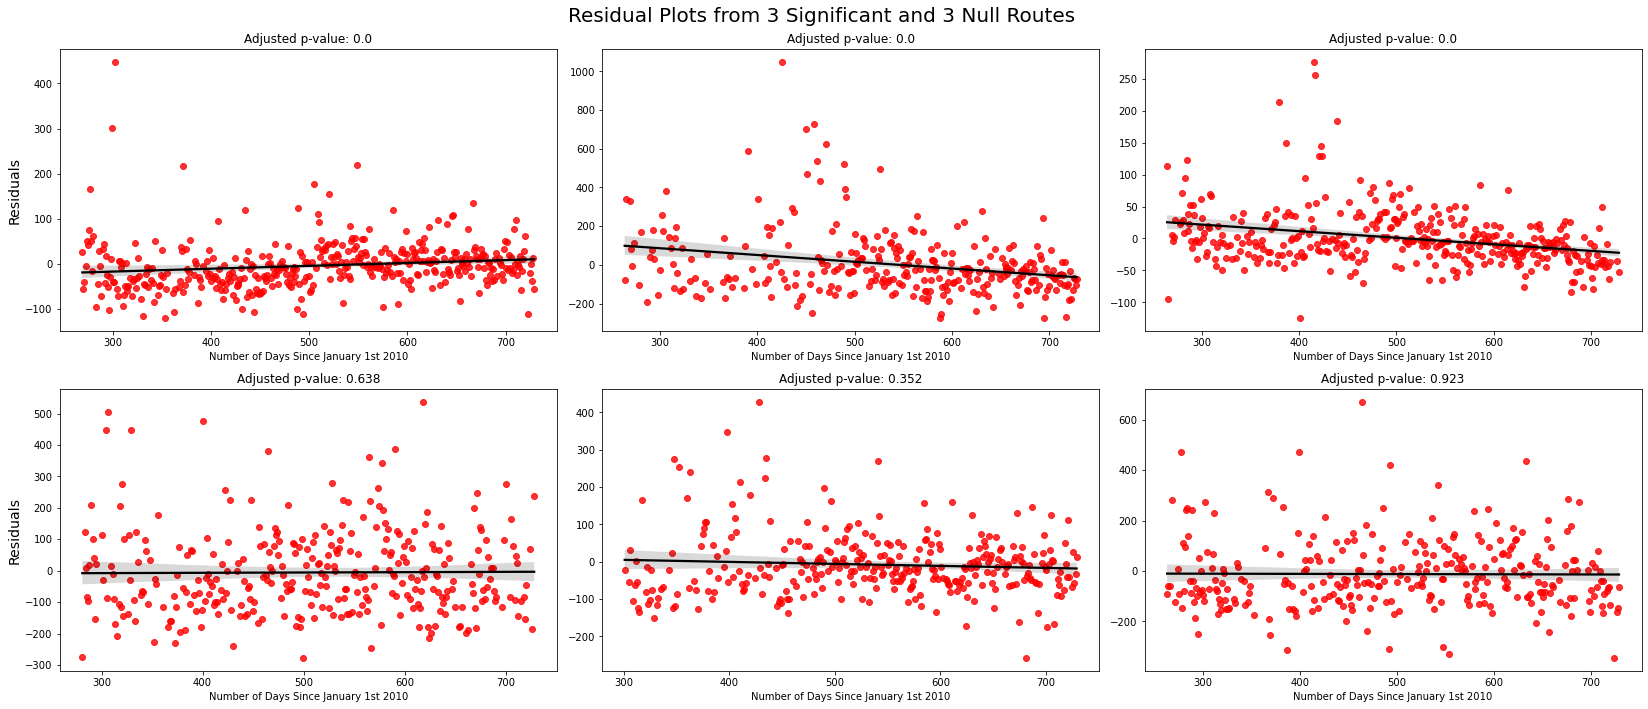

In [169]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))
p = sns.regplot(ax=axes[0, 0], x=plot_days_since[0], y=plot_resid[0], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
p.set_ylabel('Residuals', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')
# sns.residplot(ax=axes[0, 1], x=lst_days_since[3], y=lst_residuals[3])

p = sns.regplot(ax=axes[0, 1], x=plot_days_since[1], y=plot_resid[1], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[0, 2], x=plot_days_since[2], y=plot_resid[2], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 0], x=plot_days_since[3], y=plot_resid[3], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[3]],3)}')
p.set_ylabel('Residuals', fontsize=14)
p.set_xlabel('Number of Days Since January 1st 2010')


p = sns.regplot(ax=axes[1, 1], x=plot_days_since[4], y=plot_resid[4], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[4]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')

p = sns.regplot(ax=axes[1, 2], x=plot_days_since[5], y=plot_resid[5], line_kws={
                "color": "black"}, scatter_kws={"color": "red"})
axes[1, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[5]],3)}')
p.set_xlabel('Number of Days Since January 1st 2010')


plt.suptitle(
    'Residual Plots from 3 Significant and 3 Null Routes ', fontsize=20)
plt.tight_layout()


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(23, 10))
p = sns.residplot(ax=axes[0, 0], x=lst_days_since[0], y=lst_residuals[0])
p.set_ylabel('Residuals', fontsize=14)
axes[0, 0].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[0]],3)}')

sns.residplot(ax=axes[0, 1], x=lst_days_since[1], y=lst_residuals[1])
axes[0, 1].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[1]],3)}')

sns.residplot(ax=axes[0, 2], x=lst_days_since[2], y=lst_residuals[2])
axes[0, 2].set_title(
    f'Adjusted p-value: {np.around(corrected_pvals[significant_routes[2]],3)}')


plt.yscale('log')
p = sns.residplot(ax=axes[1, 0], x=lst_days_since[0], y=lst_residuals[0])
p.set_ylabel('Log (Residuals)', fontsize=14)
p.set_yscale('log')


p = sns.residplot(ax=axes[1, 1], x=lst_days_since[1], y=lst_residuals[1])
p.set_yscale('log')

p = sns.residplot(ax=axes[1, 2], x=lst_days_since[2], y=lst_residuals[2], )
plt.yscale('log')
plt.suptitle('Residual Plots from Three Null Routes', fontsize=20)
plt.tight_layout()
